# 6 Features 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns

%matplotlib inline
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('husl')

import warnings
warnings.filterwarnings('ignore')

In [2]:
# color hex code
Blue = '#4285FA'
Red = '#EA4335'
Yellow = '#FBBC05'
Green = '#34A853'

In [3]:
loan = pd.read_csv('loan_df.csv')
pd.set_option('display.max_columns', None)

In [4]:
from sklearn.model_selection import train_test_split

X = loan[['int_rate', 'total_acc', 'revol_util', 'grade_encoder', 'dti', 'emp_length']]
y = loan['is_default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

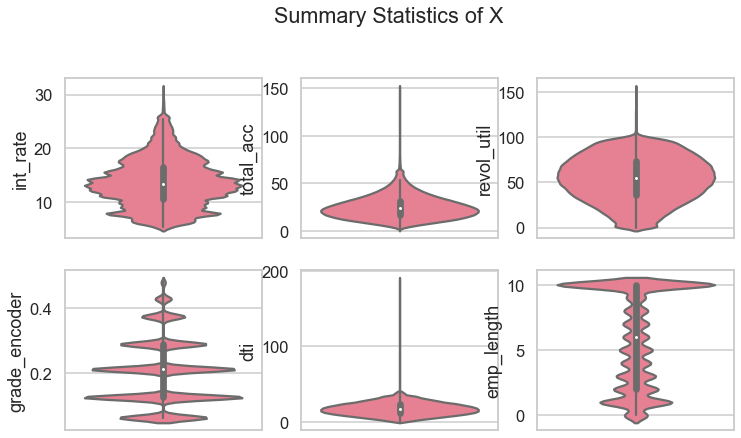

In [5]:
plt.figure(figsize=(12,10))
for i, c in enumerate(X):
    plt.subplot(3,3, i+1)
    sns.violinplot(y=c, data=X)

plt.suptitle('Summary Statistics of X')    
plt.show()

In [6]:
category = X_train.columns.difference(['int_rate', 'total_acc', 'revol_util', 'dti'])

In [7]:
from sklearn.preprocessing import StandardScaler, RobustScaler
# Fit on Train , transform on Train & Test
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

#Scaled Train
X_train_scaled = scaler.fit_transform(X_train_scaled)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
#Scaled Test
X_test_scaled = scaler.transform(X_test_scaled)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_train.columns)

In [8]:
#Sampler Class
from imblearn.over_sampling import SMOTE, SMOTENC, ADASYN, RandomOverSampler

class Sampler(object):
    sampler = {'SMOTE': SMOTE(random_state=42),
               'SMOTENC': SMOTENC(random_state=42, 
                                  categorical_features=[X_train.columns.get_loc(c) for c in category]), 
               'ADASYN': ADASYN(random_state=42), 
               'RandomOverSampler': RandomOverSampler(random_state=42)}
    def __init__(self, name):
        self.sm = self.sampler[name]
    
    def sampling(self, X_train, y_train):
        X_sampled, y_sampled = self.sm.fit_resample(X_train, y_train)        
        return X_sampled, y_sampled

In [9]:
sampler = Sampler('SMOTENC')
X_train_SMOTENC, y_train_SMOTENC = sampler.sampling(X_train, y_train)
X_train_SMOTENC_scaled, y_train_SMOTENC_scaled = sampler.sampling(X_train_scaled, y_train)

In [10]:
sampler = Sampler('ADASYN')
X_train_ADASYN, y_train_ADASYN = sampler.sampling(X_train, y_train)
X_train_ADASYN_scaled, y_train_ADASYN_scaled = sampler.sampling(X_train_scaled, y_train)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier


class Classifier(object):
    
    classifier = {'LogisticRegression': LogisticRegression(),
                  'AdaBoost': AdaBoostClassifier(),
                  'RandomForest': RandomForestClassifier(),
                  'Neural': MLPClassifier(),
                  'XGBoost': XGBClassifier()}
    
    clf_init_param = {'LogisticRegression': {'random_state':42},
                      
                      'AdaBoost': {'random_state':42}, 
                      
                      'RandomForest': {'random_state':42}, 
                      
                      'Neural': {'random_state':42}, 
                      
                      'XGBoost': {'objective': 'binary:logistic',
                                  'max_delta_step':1,
                                  'min_child_weight':1,
                                  'random_state':42}
                     }
    def __init__(self, name):
        self.name = name
        self.model = self.classifier[name].set_params(**self.clf_init_param[name])

In [12]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_curve, auc
class Plot:
    
    def __init__(self):
        pass
    
    def confusion_matrix(y_test, y_pred):
                        
        print(f'Classification Report: \n {classification_report(y_test, y_pred, target_names=["Paid", "Default"])}')
        print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
        
        cm = confusion_matrix(y_test, y_pred)        
        print(f'\nConfusion matrix:\n{cm}')

        
        
        labels = ['Not Default', 'Default']
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, cmap=plt.cm.Blues)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)
        plt.xlabel('Predicted')
        plt.ylabel('Expected')
        plt.show()
        
    def plot_auc(y_test, y_pred_prob):
        fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
        plt.plot([0,1], [0,1], linestyle='--', color='navy')
        auc_area = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, color='orange', label='Ada (area=%.2f)'%auc_area)
        plt.xlabel('False Positive Rate'), plt.ylabel('True Positive Rate')
        plt.suptitle('Receiver Operating Characteristic')
        plt.legend()
        plt.show()

In [13]:
from skopt import BayesSearchCV
from sklearn.model_selection import StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

class Model(object):
    
    def __init__(self):
        pass
    
    def start(name, X_train, y_train, X_test):
        clf = Classifier(name)
        pipe = Pipeline([('clfr', clf.model)])
        pipe.fit(X_train, y_train)
        pipe_preds = pipe.predict(X_test)
        return pipe_preds   

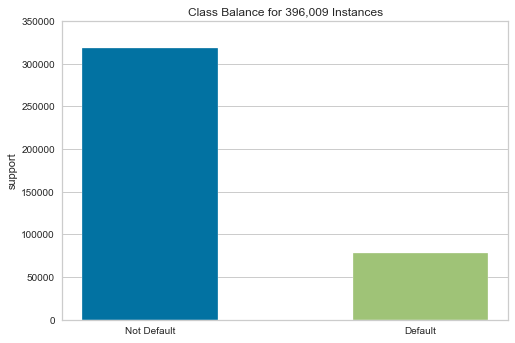

In [14]:
from yellowbrick.target import ClassBalance

def classbalance(y):
    alass = ClassBalance(labels=['Not Default', 'Default'])
    alass.fit(y)
    alass.show()

classbalance(y)

Classification Report: 
               precision    recall  f1-score   support

        Paid       0.88      0.62      0.73     63716
     Default       0.30      0.67      0.41     15486

    accuracy                           0.63     79202
   macro avg       0.59      0.64      0.57     79202
weighted avg       0.77      0.63      0.67     79202

Accuracy: 0.63

Confusion matrix:
[[39266 24450]
 [ 5107 10379]]


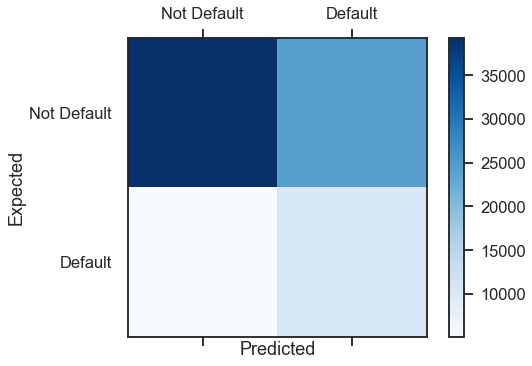

In [63]:
name = 'AdaBoost'
preds = Model.start(name, X_train_SMOTENC, y_train_SMOTENC, X_test)
Plot.confusion_matrix(y_test, preds)

## Validation

In [64]:
from sklearn.model_selection import cross_val_score
#Validation on Train
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
ada = AdaBoostClassifier(random_state=42)
score = cross_val_score(ada, X_train_SMOTENC, y_train_SMOTENC, scoring='roc_auc', cv=cv)
score.mean()

0.7100301709988422

In [68]:
X1 = pd.concat([X_train_SMOTENC, X_test])
y1 = pd.concat([y_train_SMOTENC_scaled, y_test])

In [69]:
#Validation on dataset
score1 = cross_val_score(ada, X1, y1, scoring='roc_auc', cv=cv)
score1.mean()

0.7093314101890043

## AUC


In [70]:
ada.fit(X_train_SMOTENC, y_train_SMOTENC)
ada_prob = ada.predict_proba(X_test)[:,1]

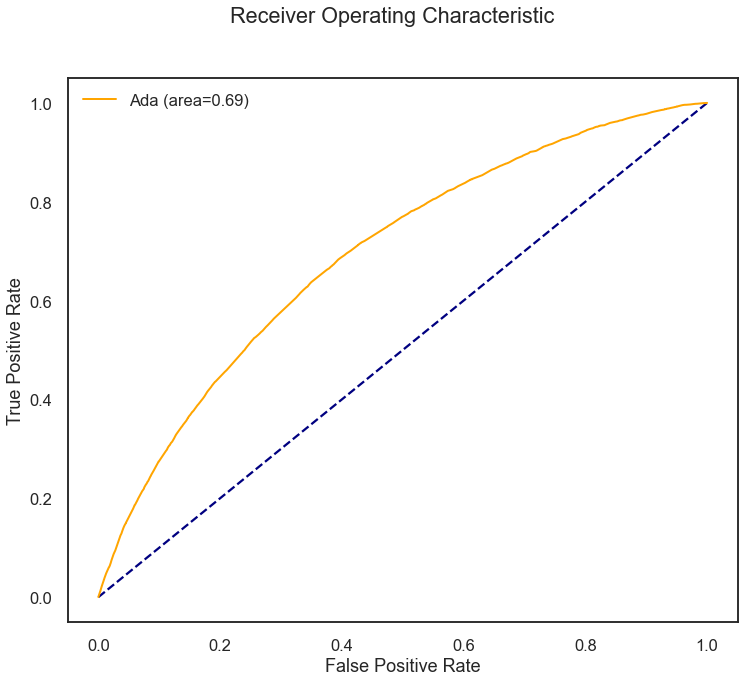

In [71]:
sns.set_context('talk')
plt.figure(figsize=(12,10))
Plot.plot_auc(y_test, ada_prob)

In [21]:
X.head()

,int_rate,total_acc,revol_util,grade_encoder,dti,emp_length
0,11.44,25.0,41.8,0.125729,26.24,10
1,11.99,27.0,53.3,0.125729,22.05,4
2,10.49,26.0,92.2,0.125729,12.79,1
3,6.49,13.0,21.5,0.062885,2.60,6
4,17.27,43.0,69.8,0.211823,33.95,9


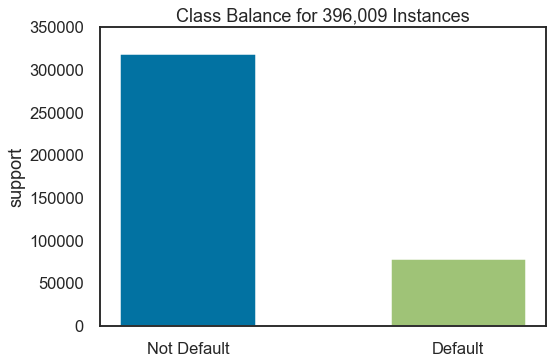

In [178]:
classbalance(y)

In [156]:
prediction = ada.predict(X)

In [157]:
prediction = pd.DataFrame(prediction, columns=['prediction'])

In [184]:
prediction.shape

(396009, 1)

In [188]:
prediction.prediction.sum()

174885

## Visualization of TimeSeries by actual vs predicted

In [191]:
df = pd.read_csv('actual.csv', parse_dates=['issue_d'])
df = pd.concat([df, prediction], axis=1)

In [193]:
df1 = df[['issue_d', 'prediction',  'loan_status' ]]
df1['loan_default'] = df1.loan_status.map({'Fully Paid': 0, 'Charged Off': 1})

In [205]:
df1['loan_paid'] = df1.loan_status.map({'Fully Paid': 1, 'Charged Off': 0})

In [206]:
df1.head()

,issue_d,prediction,loan_status,loan_default,loan_paid
0,2015-01-01,1,Fully Paid,0,1
1,2015-01-01,0,Fully Paid,0,1
2,2015-01-01,0,Fully Paid,0,1
3,2014-11-01,0,Fully Paid,0,1
4,2013-04-01,1,Charged Off,1,0


In [196]:
print(df1.loan_default.sum(), df1.prediction.sum())

77672 174885


In [207]:
a = df1.resample('M', on='issue_d').agg({'loan_default': 'sum', 'prediction': 'sum'}).reset_index()
b = df1.resample('M', on='issue_d').agg({'loan_paid': 'sum'}).reset_index()

In [201]:
print(a.loan_default.sum(), a.prediction.sum())

77672 174885


In [208]:
b.loan_paid.sum()

318337

In [214]:
mean = a.loan_default.mean()

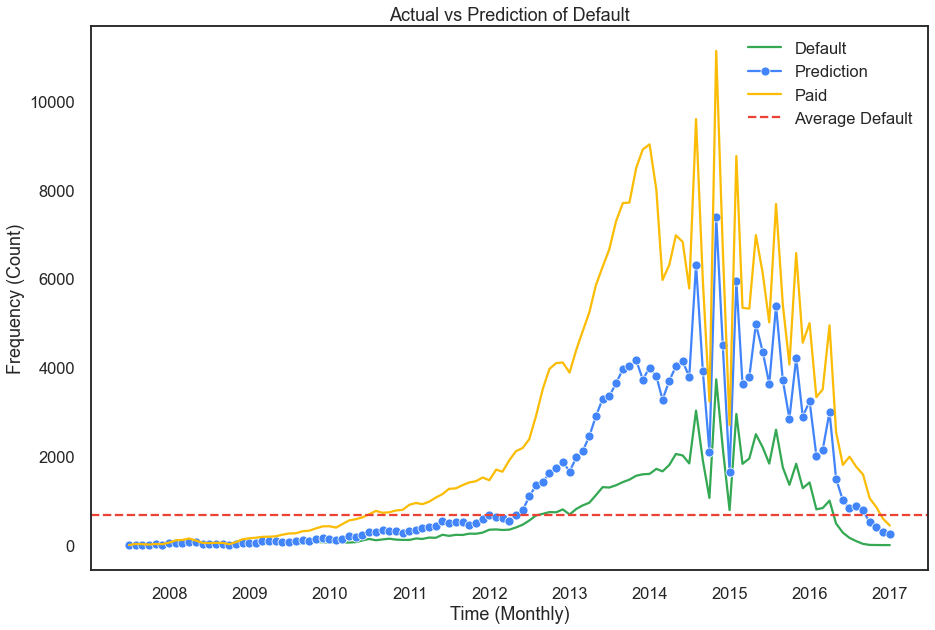

In [219]:
sns.set_style('white')
fig, ax = plt.subplots(figsize=(15,10))
sns.lineplot(a.issue_d, a.loan_default, label='Default', color=Green)
sns.lineplot(a.issue_d, a.prediction, label='Prediction', marker='o', color=Blue)
sns.lineplot(b.issue_d, b.loan_paid, label='Paid', color=Yellow)

ax.set_xlabel('Time (Monthly)'); ax.set_ylabel('Frequency (Count)'); 
ax.set_title('Actual vs Prediction of Default')
ax.axhline(mean, ls='--', color=Red, label='Average Default')
plt.legend()

## Bonus: Probability Calibration

In [49]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score

In [72]:
model = AdaBoostClassifier(random_state=42)
calibrated = CalibratedClassifierCV(model, method='sigmoid', cv=3)
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)

scorecv = cross_val_score(calibrated, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)


In [73]:
scorecv.mean()

0.6978373631483837

Classification Report: 
               precision    recall  f1-score   support

        Paid       0.89      0.62      0.73     63716
     Default       0.30      0.67      0.41     15486

    accuracy                           0.63     79202
   macro avg       0.59      0.64      0.57     79202
weighted avg       0.77      0.63      0.67     79202

Accuracy: 0.63

Confusion matrix:
[[39271 24445]
 [ 5065 10421]]


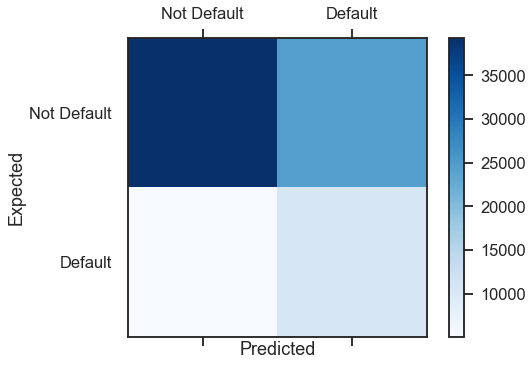

In [74]:
calibrated.fit(X_train_SMOTENC, y_train_SMOTENC)
cal_preds = calibrated.predict(X_test)
Plot.confusion_matrix(y_test, cal_preds)

Result is the same as uncalibrated model. However, the False Negative decrease by 40 units

## Hyperparameter

In [87]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [98]:
params = dict(n_estimators=[500, 1000, 2000], learning_rate=[1, 1.5, 2])

In [99]:
cv1 = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=42)
opti = RandomizedSearchCV(ada, cv=cv1, param_distributions=params, scoring='f1_weighted', verbose=3, n_jobs=-1, refit=True)

In [100]:
grid = opti.fit(X_train_SMOTENC, y_train_SMOTENC)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  45 | elapsed: 25.6min remaining: 12.8min
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed: 36.0min finished


In [109]:
grid.best_score_

0.8162463026320366

In [110]:
grid.best_estimator_

AdaBoostClassifier(learning_rate=1.5, n_estimators=2000, random_state=42)

In [111]:
grid.best_params_

{'n_estimators': 2000, 'learning_rate': 1.5}

In [107]:
grid_preds = grid.predict(X_test)
grid_preds_prob = grid.predict_proba(X_test)[:,1]

Classification Report: 
               precision    recall  f1-score   support

        Paid       0.84      0.90      0.86     63716
     Default       0.39      0.27      0.32     15486

    accuracy                           0.77     79202
   macro avg       0.61      0.58      0.59     79202
weighted avg       0.75      0.77      0.76     79202

Accuracy: 0.77

Confusion matrix:
[[57138  6578]
 [11265  4221]]


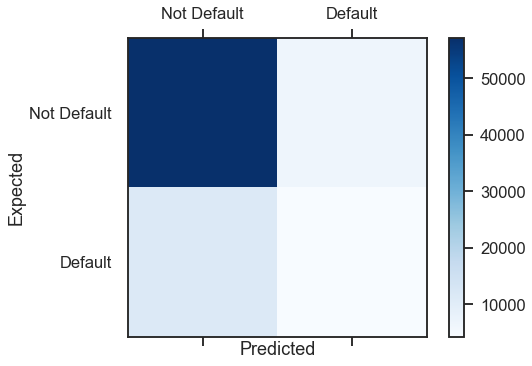

In [108]:
Plot.confusion_matrix(y_test, grid_preds)

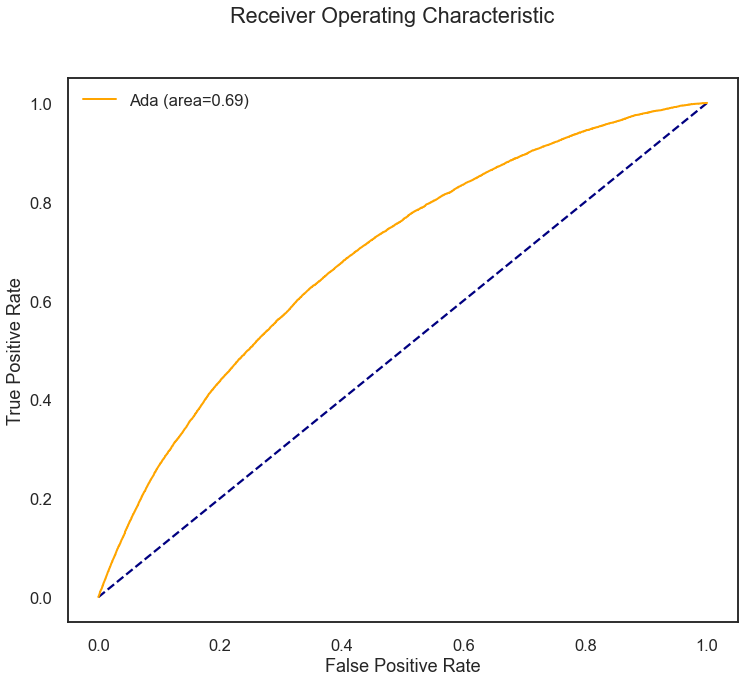

In [112]:
sns.set_context('talk')
plt.figure(figsize=(12,10))
Plot.plot_auc(y_test, grid_preds_prob)

### There is a trade-off between FN vs FP.  Hyperparameter + Calibration increase model's f1_weight score at the cost of FN. Although, my aim is to minimise the FN and identify default, therefore, I would remove the hyperparameter + calibration. Perhaps, i will come back to this problem with deeper knowledge to be able to solve it. 

### Calibrated Adaptive Boosting using SMOTENC technique with 6 features provide 67% recall, 5065 FN, 67% f1_weighted